In [1]:
"""
    -- Description:
        
        This notebook will read original tick-level trading data, and generates the following
        
        standard bars with Volume Weighted Average Price (VWAP) data: 
        
        Time Bar, Tick Bar, Volume Bar, and Dollar Bar.
        
        
    -- Prerequisite:
        
        XBTUSD Perpetual Swap Tick-Level historical trading data.
        
    -- Auther:
        
        Fang Fan (Roy)
        
    -- Date:
        
        September 2, 2020
    
""";

In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime
from glob import glob
from contextlib import contextmanager

%matplotlib inline
sns.set()

In [3]:
# Personalize Colours
dt_hex, r_hex, g_hex, tl_hex, tn_hex = '#2B4750', '#DC2624', '#649E7D', '#45A0A2', '#C89F91'

In [4]:
# Util function for recording execution duration
@contextmanager
def how_long(process_name):
    startTime = time.time()
    yield
    elapsedTime = time.time() - startTime
    print("[{}] finished in {}s".format(process_name, int(elapsedTime)))

In [5]:
# Read Tick-Level Trading History Data
df = pd.DataFrame()
trade_data_paths = sorted(glob("/data/finance_data/*.csv"))

with how_long("Loading Data"):
    for file_path in trade_data_paths:
        df = df.append(pd.read_csv(file_path))
    df = df[df["symbol"]=="XBTUSD"].reset_index(drop=True)

print(df.shape)

[Loading Data] finished in 9s
(1434823, 10)


In [6]:
# Parse Time Stamp and Update the Column

with how_long("Parsing Timestamps"):
    df["timestamp"] = df["timestamp"].map(
        lambda x: datetime.strptime(x[:-3], "%Y-%m-%dD%H:%M:%S.%f")
    )

[Parsing Timestamps] finished in 41s


In [7]:
# Show Data
df.head(3).append(df.tail(3))

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
0,2019-04-19 00:00:08.318873,XBTUSD,Sell,10,5278.0,MinusTick,f62c0ad2-c165-3446-a99e-d081c2e6ea65,189470,0.001895,10.0
1,2019-04-19 00:00:08.367122,XBTUSD,Sell,22959,5278.0,ZeroMinusTick,46a184e2-ef8c-aa5e-fb90-81f325174fa5,435004173,4.350042,22959.0
2,2019-04-19 00:00:08.449684,XBTUSD,Buy,510,5278.5,PlusTick,ac2befd6-ccc8-9fac-be93-75b686565d07,9661950,0.096620,510.0
1434820,2019-04-22 23:59:54.831787,XBTUSD,Sell,14690,5382.5,ZeroMinusTick,7139ea9f-fb14-ee82-3740-d3edf3206685,272925510,2.729255,14690.0
1434821,2019-04-22 23:59:59.321668,XBTUSD,Buy,3514,5383.0,PlusTick,f9e494c7-d5ac-453e-737f-e2ca6875d279,65279578,0.652796,3514.0
1434822,2019-04-22 23:59:59.321668,XBTUSD,Buy,6486,5383.0,ZeroPlusTick,81439489-8f7e-6cf2-3ab9-e77be2e07f4a,120490422,1.204904,6486.0


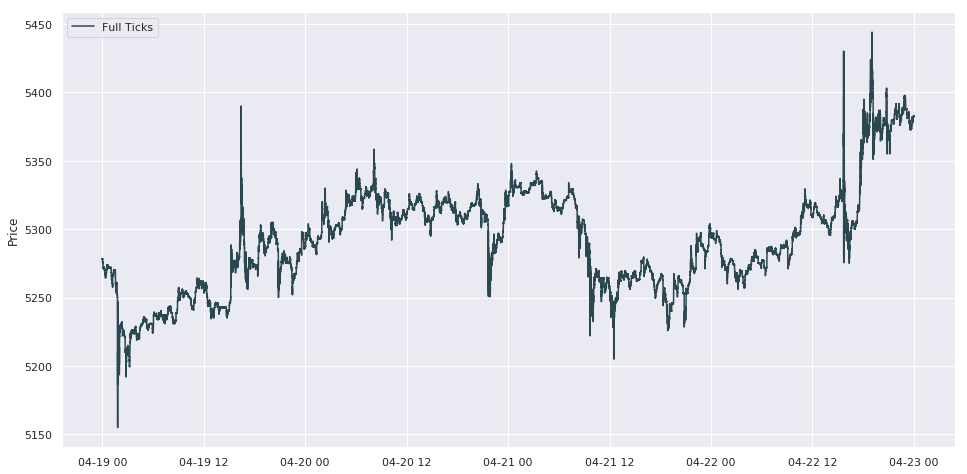

In [8]:
# Plot Original Full Tick Price Data
plt.figure(figsize=(16,8))
plt.plot(df["timestamp"], df["price"], label="Full Ticks", color=dt_hex)
plt.legend(frameon=True, loc=0)
plt.ylabel("Price");

# Time Bar

In [9]:
# Each time bar has 15min's tick data
df_time = df.set_index("timestamp")

In [10]:
time_group = df_time.groupby(pd.Grouper(freq="15min"))

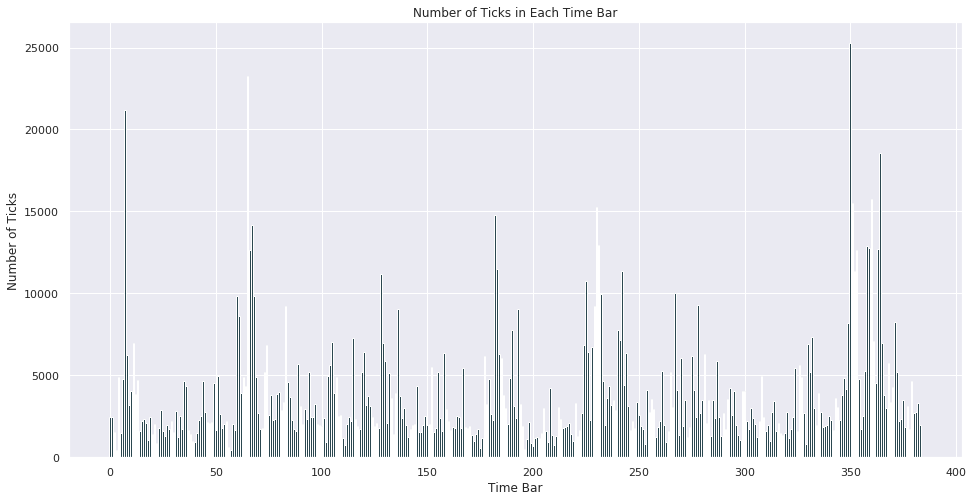

In [11]:
# Overview of Tick Distribution
bar_sizes = time_group.size().values

plt.figure(figsize=(16, 8))
plt.bar(np.arange(len(bar_sizes)), bar_sizes, color=dt_hex)
plt.title("Number of Ticks in Each Time Bar")
plt.xlabel("Time Bar")
plt.ylabel("Number of Ticks");

In [12]:
def calculate_vwap(data):
    """
    Calculate the Volume Weighted Average Price (VWAP).
    """
    volume_vec = data["homeNotional"]
    price_vec = data["price"]
    volume_weighted_average_price = np.dot(volume_vec, price_vec) / volume_vec.sum()
    data["vwap"] = volume_weighted_average_price
    return data

In [13]:
# Calculate VWAP for Time Bar

with how_long("VWAP"):
    data_by_time = time_group.apply(calculate_vwap).groupby(pd.Grouper(freq="15min")).agg(np.mean)

[VWAP] finished in 1s


In [14]:
# Get VWAP for Each Bar, and Its Corresponding Timestamp
t_time = data_by_time.index
vwap_time = data_by_time["vwap"].values

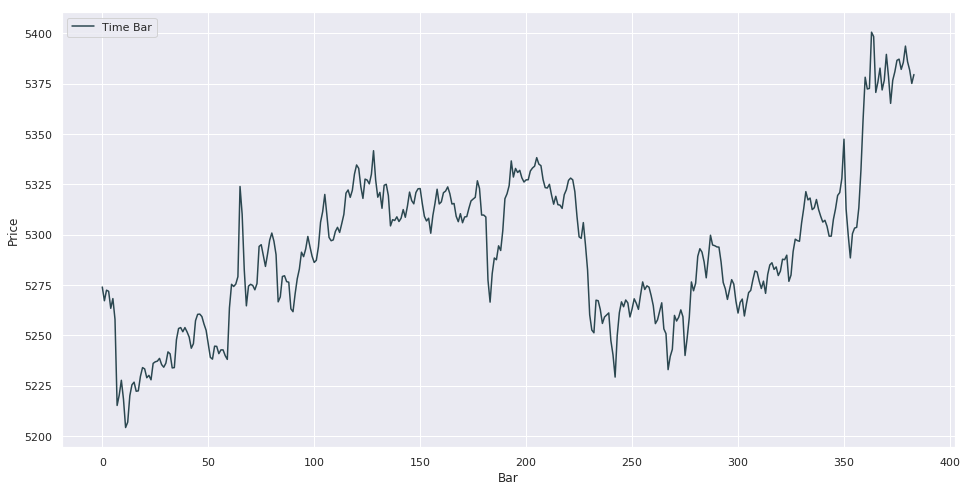

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(vwap_time)), vwap_time, color=dt_hex, label="Time Bar")
plt.legend(frameon=True, loc=0)
plt.ylabel("Price")
plt.xlabel("Bar");

# Tick Bar

In [ ]:
# Number of bars for Time Bars
total_number_of_bars = len(time_group)
print(total_number_of_bars)

384


In [ ]:
# Calculate how many ticks in each bar:
ticks_per_bar = int(round(len(df) / total_number_of_bars,-2))
print(ticks_per_bar)

3700


In [ ]:
# Tag Tick Bar groupID
df_tick = df.assign(groupID=df.index // ticks_per_bar)

In [ ]:
tick_group = df_tick.groupby("groupID")

In [ ]:
with how_long("VWAP"):
    data_by_tick = tick_group.apply(calculate_vwap).groupby("groupID").agg(np.mean)

[VWAP] finished in 2s


In [ ]:
# Get VWAP for Each Bar, and Its Corresponding Timestamp
idx_tick = (np.cumsum(tick_group.size()) - 1).values

t_tick = df.loc[idx_tick].timestamp.values
vwap_tick = data_by_tick["vwap"].values

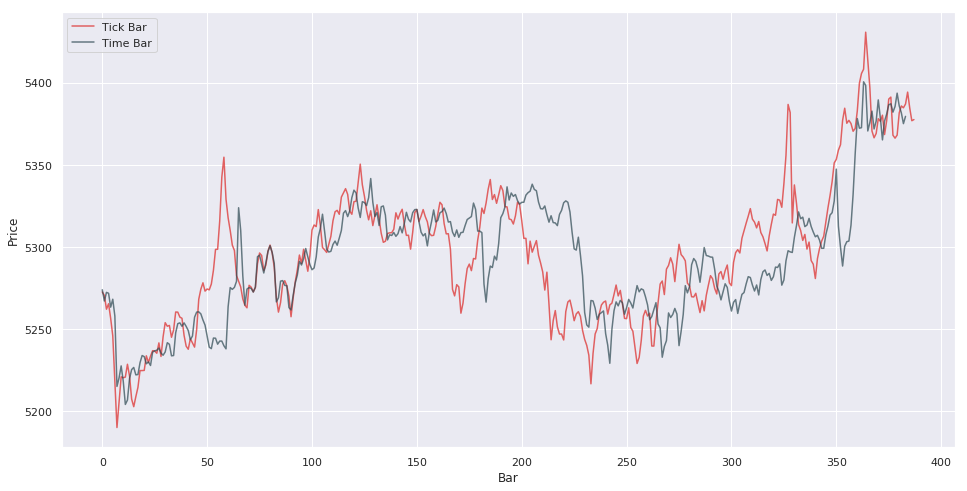

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(vwap_tick)), vwap_tick, color=r_hex, label="Tick Bar", alpha=0.7)
plt.plot(np.arange(len(vwap_time)), vwap_time, color=dt_hex, label="Time Bar", alpha=0.7)
plt.legend(frameon=True, loc=0)
plt.ylabel("Price")
plt.xlabel("Bar");

# Volume Bar

In [ ]:
df_volume = df.assign(cumuVol=np.cumsum(df["homeNotional"]))

In [ ]:
# Calculate how many ticks in each bar:
total_volume = df_volume["cumuVol"].iloc[-1]
volume_per_bar = int(round(total_volume / total_number_of_bars, -2))
print(volume_per_bar)

2700


In [ ]:
# Tag Volume Bar groupID
df_volume["groupID"] = df_volume["cumuVol"] // volume_per_bar

In [ ]:
volume_group = df_volume.groupby("groupID")

In [ ]:
with how_long("VWAP"):
    data_by_volume = volume_group.apply(calculate_vwap).groupby("groupID").agg(np.mean)

In [ ]:
# Get VWAP for Each Bar, and Its Corresponding Timestamp
idx_volume = np.cumsum(volume_group.size()).values - 1

t_volume = df.loc[idx_volume]["timestamp"].values
vwap_volume = data_by_volume["vwap"]

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(vwap_volume)), vwap_volume, color=tn_hex, label="Volume Bar", alpha=1)
plt.plot(np.arange(len(vwap_time)), vwap_time, color=dt_hex, label="Time Bar", alpha=0.7)
plt.legend(frameon=True, loc=0)
plt.ylabel("Price")
plt.xlabel("Bar");

# Dollar Bar

In [ ]:
df_dollar = df.assign(cumuDol=np.cumsum(df["foreignNotional"]))

In [ ]:
# Calculate how many ticks in each bar:
total_dollar = df_dollar["cumuDol"].iloc[-1]
dollar_per_bar = int(round(total_dollar / total_number_of_bars, -2))
print(dollar_per_bar)

In [ ]:
## Tag Dollar Bar groupID
df_dollar["groupID"] = df_dollar["cumuDol"] // dollar_per_bar

In [ ]:
dollar_group = df_dollar.groupby("groupID")

In [ ]:
with how_long("VWAP"):
    data_by_dollar = dollar_group.apply(calculate_vwap).groupby("groupID").agg(np.mean)

In [ ]:
# Get VWAP for Each Bar, and Its Corresponding Timestamp
idx_dollar = np.cumsum(dollar_group.size()).values - 1

t_dollar = df.loc[idx_dollar]["timestamp"].values
vwap_dollar = data_by_dollar["vwap"]

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(vwap_dollar)), vwap_dollar, color=g_hex, label="Dollar Bar", alpha=0.7)
plt.plot(np.arange(len(vwap_time)), vwap_time, color=dt_hex, label="Time Bar", alpha=0.8)
plt.legend(frameon=True, loc=0)
plt.ylabel("Price")
plt.xlabel("Bar");